In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import logging
import pickle

import numpy as np

import py21cmfast as p21c

sys.path.append("..")
from dm21cm.dm_params import DMParams
from dm21cm.evolve import evolve
import dm21cm.physics as phys

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file("../matplotlibrc")

/n/home07/yitians/.conda/envs/21cmfast/lib/python3.10/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/21cmfast/lib/python3.10/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")
INFO:root:Using 21cmFAST version 0.1.dev1579+g6b1da6d.d20230702


## config

In [2]:
print(os.cpu_count())

48


In [3]:
# check cached runs
l = os.listdir(os.environ['P21C_CACHE_DIR'])
l.sort()
[print(i) for i in l];

phph_dhinit_s8zero
phph_dhinit_s8zero_fine


## run

In [6]:
dd = evolve(
    run_name = 'phph_dhinit_s8zero',
    run_mode = 'bath',
    z_start = 44,
    z_end = 6,
    zplusone_step_factor = 1.05,
    dm_params = DMParams(
        mode = 'swave',
        primary = 'phot_delta',
        m_DM = 1e10,
        sigmav = 1e-23,
    ),
    struct_boost_model = 'erfc 1e-3',
    enable_elec = False,
    dhinit_list = ['phot', 'T_k', 'x_e'],
    dhtf_version = '230408x',
    
    p21c_initial_conditions = p21c.initial_conditions(
        user_params = p21c.UserParams(
            HII_DIM = 50, # [1] | base: 50
            BOX_LEN = 50, # [p-Mpc] | base: 50
            N_THREADS = 32
        ),
        cosmo_params = p21c.CosmoParams(
            OMm = 0.32,
            OMb = 0.049,
            POWER_INDEX = 0.96,
            SIGMA_8 = 1e-10, # base 0.83
            hlittle = 0.67
        ),
        random_seed = 54321,
        write = True,
    ),
    
    rerun_DH = False,
    clear_cache = True,
    force_reload_tf = False,
    use_tqdm = True,
    save_slices = True,
    debug = True,
    #debug_xe_func = interpolate.interp1d(soln['rs']-1, soln['x'][:,0]),
)

100%|███████████████████████████████████████████████████████████████████████████████████| 38/38 [01:29<00:00,  2.36s/it]

input used 43.1701 s
p21c used 45.8639 s


## debug

In [8]:
soln = pickle.load(open('../data/run_info/DH/phph_caseA_in_reion_soln.p', 'rb'))

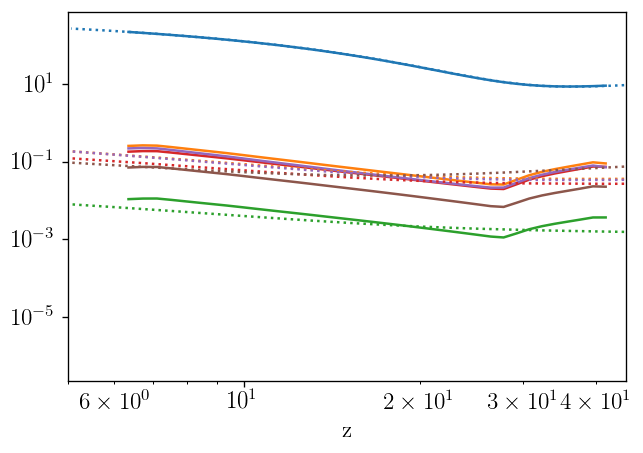

In [9]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL+1)

f = np.array(dd['f'])

plt.plot(dd['z'], dd['photEtot'], color='C0')
for i in range(5):
    plt.plot(dd['z'], f[:,i], color=f'C{i+1}')

plt.plot(soln['rs']-1, [s.toteng() for s in soln['highengphot']], color='C0', ls=':')
for i, k in enumerate(soln['f']['low']):
    plt.plot(soln['rs']-1, soln['f']['low'][k] + soln['f']['high'][k], color=f'C{i+1}', ls=':')

plt.xlim(5, 45)

plt.xlabel('z')
plt.loglog();

In [94]:
r = np.load("../data/run_info/phph_dhinit_s8zero_records.npy", allow_pickle=True).item()

In [79]:
rfine = np.load("../data/run_info/phph_dhinit_s8zero_fine_records.npy", allow_pickle=True).item()

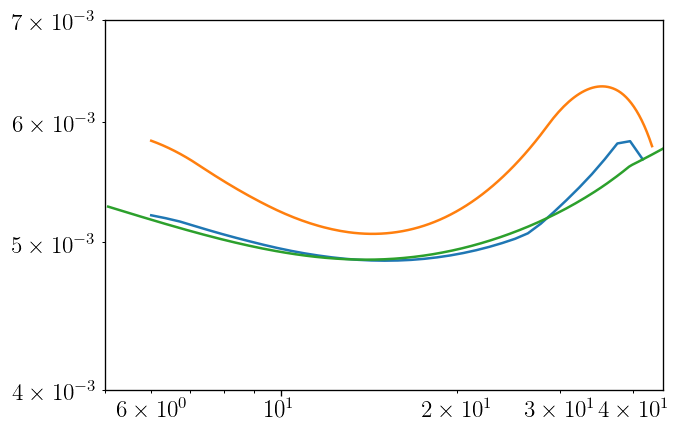

In [95]:
# x_e
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL+1)
plt.plot(r['z'], r['x_e'])
plt.plot(rfine['z'], rfine['x_e'])
plt.plot(soln['rs']-1, soln['x'][:,0])
plt.xlim(5, 45)
plt.ylim(4e-3, 7e-3)
plt.loglog();

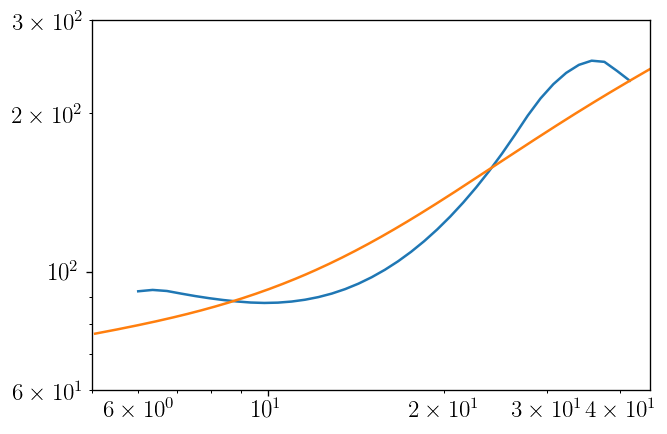

In [97]:
# T_k
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL+1)
plt.plot(r['z'], r['T_k'])
plt.plot(soln['rs']-1, soln['Tm']/phys.kB)
plt.xlim(5, 45)
plt.ylim(6e1, 3e2)
plt.loglog();

In [37]:
! ls ../data/run_info/

base_dhinit_records.npy		  phph_dhinit_records.npy
base_records.npy		  phph_dhinit_s8zero_fine_records.npy
base_zfine_records.npy		  phph_dhinit_s8zero_records.npy
compdh_base_dhinit_records.npy	  phph_dhinit_s8zero_slices.npy
compdh_base_finestep_records.npy  phph_records.npy
compdh_base_records.npy		  xray_bath_test_records.npy
DH				  xray_test_all_to_unif_records.npy
phph_dhinit_fine_records.npy	  xray_test_records.npy


In [105]:
soln['rs'][380], soln['x'][380]

(31.386176830284736, array([5.25000352e-03, 5.43939893e-14]))

In [106]:
from dm21cm.data_loader import load_data

In [111]:
import jax.numpy as jnp

In [107]:
dep_tf = load_data('phot_dep')

In [108]:
dm_params = DMParams(
    mode = 'swave',
    primary = 'phot_delta',
    m_DM = 1e10,
    sigmav = 1e-23,
)

INFO:root:Using 21cmFAST version 0.1.dev1579+g6b1da6d.d20230702
INFO:root:Using 21cmFAST version 0.1.dev1579+g6b1da6d.d20230702
INFO:root:Using 21cmFAST version 0.1.dev1579+g6b1da6d.d20230702
INFO:root:Using 21cmFAST version 0.1.dev1579+g6b1da6d.d20230702
INFO:root:Using 21cmFAST version 0.1.dev1579+g6b1da6d.d20230702
INFO:root:Using 21cmFAST version 0.1.dev1579+g6b1da6d.d20230702
INFO:root:Using 21cmFAST version 0.1.dev1579+g6b1da6d.d20230702
INFO:root:Using 21cmFAST version 0.1.dev1579+g6b1da6d.d20230702


In [117]:
dep_tf(in_spec=dm_params.inj_phot_spec.N, sum_result=False, rs = 31.386176830284736,
       nBs_s = jnp.array([1.]),
       x_s = jnp.array([5.25000352e-03]),
       out_of_bounds_action = 'clip',) / dm_params.eng_per_inj

Array([[1.3091041e-08, 2.0636985e-10, 1.1116971e-08, 1.0780063e-08,
        1.8104429e-09, 4.9824688e-05]], dtype=float32)

In [114]:
[soln['f']['low'][k][380]+soln['f']['high'][k][380] for k in soln['f']['low']]

[0.03712726873128162,
 0.0017520660795353245,
 0.0279125775366538,
 0.034532229237314485,
 0.05640522406332396]

In [116]:
dep_tf.abscs['x']

array([1.0000e-05, 1.0000e-04, 1.0000e-03, 1.0000e-02, 1.0000e-01,
       3.0000e-01, 7.0000e-01, 9.0000e-01, 9.9900e-01, 9.9999e-01])

In [55]:
s = np.load("../data/run_info/phph_dhinit_s8zero_slices.npy", allow_pickle=True)